In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from src.utils import get_dataset, get_cc_mat

### Get data

In [3]:
df = get_dataset(
    labels_file="./data/class_vector_train_ref.mat", 
    params_file="./data/training_set_ref.mat",
    names_file="./data/paremeterNames.mat"
)

print(f'***Dataset shape: {df.shape}')

# Value counts of the stability label
print('***Value counts of the stability label:')
print(df['label'].value_counts(normalize=True).round(4))

df.head()

***Dataset shape: (200000, 259)
***Value counts of the stability label:
0    0.5287
1    0.4713
Name: label, dtype: float64


,BIO@atp_c,BIO@pyr_c,BIO@nad_c,BIO@g6p_c,BIO@oaa_c,BIO@f6p_c,BIO@nadph_c,BIO@nh4_c,BIO@o2_c,BIO@r5p_c,...,D_LAC@feri_m,D_LAC@lac_m,SUCCt2r@suc_c,MALt2r@mal_c,CITt2m@mal_c,CITt2m@cit_m,CITt2m@mal_m,CITt2m@cit_c,PFK@amp_c,label
0,0.457634,0.014440,0.058212,0.676883,0.341359,0.662601,0.558494,0.469465,0.379688,0.031882,...,0.310612,0.176318,0.750574,0.835077,0.636952,0.805681,0.314653,0.601644,0.442062,1
1,0.011809,0.879388,0.003459,0.746891,0.306732,0.324433,0.790872,0.561433,0.601143,0.729455,...,0.260641,0.480122,0.828887,0.774984,0.793254,0.111233,0.174306,0.035144,0.432545,1
2,0.150170,0.442691,0.029388,0.930178,0.904467,0.690296,0.083225,0.292097,0.122153,0.097039,...,0.780362,0.548510,0.591525,0.579699,0.168482,0.214867,0.430102,0.757192,0.281138,1
3,0.241337,0.108236,0.874900,0.908554,0.945598,0.204189,0.396873,0.474224,0.738103,0.958655,...,0.998683,0.015408,0.362024,0.127115,0.230577,0.996991,0.195371,0.013773,0.316083,1
4,0.357361,0.179095,0.737178,0.371373,0.562450,0.809965,0.920162,0.750900,0.623332,0.356794,...,0.298213,0.555471,0.611591,0.020826,0.543747,0.459455,0.110901,0.838803,0.561902,1


### Feature Selection

In [ ]:
from mrmr import mrmr_classif
selected_features = mrmr_classif(X=df.drop('label', axis=1), y=df['label'], K=10)

for i in selected_features:
    print(i)

### ML

### FFC

In [4]:
enzyme, commonEnz, allEnzymes, \
    commonConCoeff, allConCoeff = get_cc_mat('./data/ccXTR_ref.mat')


Enzyme: XTR
Common enzymes: ['HXK', 'PGI', 'TPI', 'ZWF', 'ATPM', 'ADK', 'NDR', 'PDA', 'XTR', 'XRI', 'XDH', 'XK']
Number of all enzymes: 86


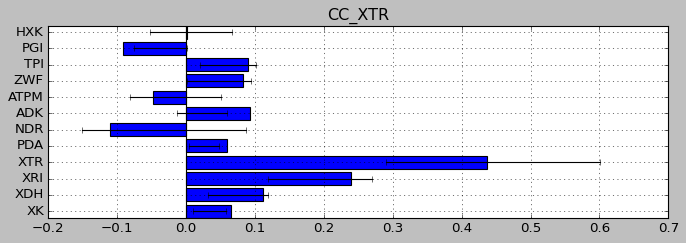

In [29]:
# Change plot style
plt.style.use('classic')

# Calculate the 1st and 3rd quartiles of commonConCoeff values
q1 = commonConCoeff.quantile(0.25)
q3 = commonConCoeff.quantile(0.75)

# Plot the mean of commonConCoeff values
plt.figure(figsize=(10, 3))
plt.barh(commonConCoeff.columns[::-1], commonConCoeff.mean()[::-1])
plt.axvline(x=0, color='black', linestyle='-')
plt.plot(q1, commonConCoeff.columns, '|', color='black', label='Q1', alpha=1)
plt.plot(q3, commonConCoeff.columns, '|', color='black', label='Q3', alpha=1)
for i, enzyme in enumerate(commonConCoeff.columns):
    plt.plot([q1[i], q3[i]], [enzyme, enzyme], color='black')
plt.title("CC_XTR")
plt.grid()
plt.show()

In [30]:
idx_HXK = commonConCoeff[commonConCoeff['HXK'] < 0].index
df_HXK = df.drop('label', axis=1)
df_HXK['label'] = [1 if i in idx_HXK else 0 for i in df_HXK.index]
df_HXK['label'].value_counts(normalize=True).round(4)

0    0.5287
1    0.4713
Name: label, dtype: float64

In [31]:
from sklearn.model_selection import train_test_split

X = df_HXK.drop('label', axis=1)
y = df_HXK['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

print(f'Traininig set shape: {X_train.shape}')
print(f'Test set shape: {X_test.shape}')

Traininig set shape: (40000, 258)
Test set shape: (160000, 258)


In [32]:
# Simple torch ANN for classification
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class ANN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out
    
input_dim = X_train.shape[1]
hidden_dim = 256
output_dim = 1

model = ANN(input_dim, hidden_dim, output_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)

n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
        
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

model.eval()
y_pred = model(X_test_tensor)
y_pred = y_pred.detach().numpy().round()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1: {f1_score(y_test, y_pred)}')
print(f'MCC: {matthews_corrcoef(y_test, y_pred)}')

Epoch 0, Loss: 0.6773248314857483
Accuracy: 0.68805
Precision: 0.651593035650835
Recall: 0.7285657528804131
F1: 0.6879329748655746
MCC: 0.38039025237971824


In [66]:
import shap 

# Calculate shap values for the ANN model
def f(x):
    return model(torch.tensor(x, dtype=torch.float32)).detach().numpy()

X_shap = shap.utils.sample(X_train, 100)
explainer = shap.KernelExplainer(f, X_shap)

In [69]:
shap_values = explainer.shap_values(X_train.sample(300)) 

  0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 

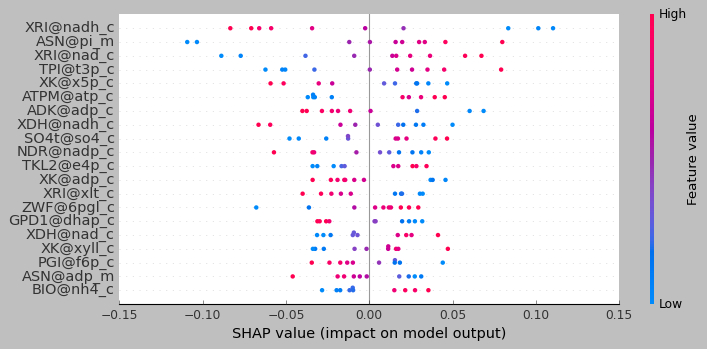

In [61]:
fig = plt.figure()
shap.summary_plot(shap_values[0], X_shap, plot_type='dot', show=False)
plt.gcf().set_size_inches(10,4)
plt.show()
